In [103]:
import pandas as pd
import re
import numpy as np
import gensim
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [160]:
# spacy for lemmatization
# import spacy
# from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
lemmatizer = WordNetLemmatizer()

import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [105]:
# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

### Loading data

In [106]:
import os
pwd = os.getcwd()

In [108]:
emails = pd.read_csv(os.path.basename(pwd +'/emails.csv'))
email_subset = emails.sample(frac=0.05, random_state=1)
print(email_subset.shape)
print(email_subset.head())

(25870, 2)
                              file  \
186822  jones-t/all_documents/634.   
308790  mann-k/all_documents/5690.   
82383         dasovich-j/sent/423.   
227299          kaminski-v/var/63.   
301824     mann-k/_sent_mail/3208.   

                                                  message  
186822  Message-ID: <17820178.1075846925335.JavaMail.e...  
308790  Message-ID: <29110382.1075845717882.JavaMail.e...  
82383   Message-ID: <6812040.1075843194135.JavaMail.ev...  
227299  Message-ID: <21547648.1075856642126.JavaMail.e...  
301824  Message-ID: <12684200.1075846107179.JavaMail.e...  


### Data Cleaning
- We have to do topic modelling on text data, I have removed redundant imformation and kept only: email body , From and To.
- I am only using first 10,000 emails

In [115]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to', 'date']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [116]:
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from'),
        'date': map_to_list(emails, 'date')
    }

In [117]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [134]:
email_df = pd.DataFrame(parse_into_emails(email_subset.message))
email_df.head()

,body,to,from_,date
0,"It would be nice if you could be at my dinner,...",alicia.goodrow@enron.com,tana.jones@enron.com,"Tue, 4 Jan 2000 08"
1,Absolutely.Good point! Can Peter start to dra...,Kay Mann/Corp/Enron@ENRON,Sheila Tweed@ECT on 05/15/2001 06,"Tue, 15 May 2001 11"
2,My apologies. My schedule melted down after w...,christine.piesco@oracle.com,jeff.dasovich@enron.com,"Thu, 28 Sep 2000 08"
3,"Vince,UK VAR breached the limit last week.UK t...","Richard Lewis/LON/ECT@ECT, James New/LON/ECT@E...",tanya.tamarchenko@enron.com,"Mon, 9 Oct 2000 01"
4,Any problems/comments?AM ---------------------...,"Don Hammond/PDX/ECT@ECT, Jody Blackburn/PDX/EC...",kay.mann@enron.com,"Fri, 13 Oct 2000 01"


In [135]:
email_df['date'] = email_df['date'].str[4:16]
email_df.head()

,body,to,from_,date
0,"It would be nice if you could be at my dinner,...",alicia.goodrow@enron.com,tana.jones@enron.com,4 Jan 2000
1,Absolutely.Good point! Can Peter start to dra...,Kay Mann/Corp/Enron@ENRON,Sheila Tweed@ECT on 05/15/2001 06,15 May 2001
2,My apologies. My schedule melted down after w...,christine.piesco@oracle.com,jeff.dasovich@enron.com,28 Sep 2000
3,"Vince,UK VAR breached the limit last week.UK t...","Richard Lewis/LON/ECT@ECT, James New/LON/ECT@E...",tanya.tamarchenko@enron.com,9 Oct 2000
4,Any problems/comments?AM ---------------------...,"Don Hammond/PDX/ECT@ECT, Jody Blackburn/PDX/EC...",kay.mann@enron.com,13 Oct 2000


In [136]:
# To check there are no empty columns
email_df.drop(email_df.query(
    "body == '' | to == '' | from_ == '' | date == ''"
).index, inplace=True)

### Remove punctuation/lower casing
- Preprocessing on the content to make it more amenable for analysis

In [137]:
# Remove punctuation
email_df['text_processed'] = \
email_df['text_processed'] = email_df['body'].str.replace(r'[^\w\s]','')
# Convert the textto lowercase
email_df['text_processed'] = \
email_df['text_processed'].map(lambda x: x.lower())
email_df['text_processed'].head()

0    it would be nice if you could be at my dinner ...
1    absolutelygood point  can peter start to draft...
2    my apologies  my schedule melted down after we...
3    vinceuk var breached the limit last weekuk tra...
4    any problemscommentsam dale rasmussenectmannco...
Name: text_processed, dtype: object

### Exploratory Analysis
Wordcloud package to get a visual representation of most common words

In [140]:
# Import the wordcloud library
from wordcloud import WordCloud

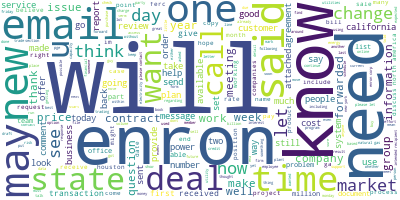

In [141]:
# Join the different processed titles together.
long_string = ','.join(list(email_df['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()


### LDA Analysis : Transform data in a format that will serve as an input for training LDA model

In [142]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Analyzing text with TF-IDF

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(email_df.text_processed)

In [146]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [147]:
print(email_df.iloc[2]['text_processed'])

my apologies  my schedule melted down after we talked on monday  hereswhere folks came out  theres some concern about size  were supposed to beno larger than 3 but we lobbied aceves and he apparently okd ouroversized group  the other folks in the groupwho talked to himoriginallyare pretty sure that five will violate the rules  folks wonderedif there were other groups that are smaller than ours that you could hook upwith  sorry about thatits a wrinkle that i didnt think about when wespoke  if it gets real ugly trying to find a smaller group let me knowfortunately theres not another team case due for two weeksbestjeff


In [148]:
data = email_df.text_processed.values.tolist()

In [163]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(i) for i in sent])
    return texts_out

In [150]:
data_words = list(sent_to_words(data))

In [151]:
print(data_words[2])

['my', 'apologies', 'my', 'schedule', 'melted', 'down', 'after', 'we', 'talked', 'on', 'monday', 'hereswhere', 'folks', 'came', 'out', 'theres', 'some', 'concern', 'about', 'size', 'were', 'supposed', 'to', 'beno', 'larger', 'than', 'but', 'we', 'lobbied', 'aceves', 'and', 'he', 'apparently', 'okd', 'ouroversized', 'group', 'the', 'other', 'folks', 'in', 'the', 'groupwho', 'talked', 'to', 'pretty', 'sure', 'that', 'five', 'will', 'violate', 'the', 'rules', 'folks', 'wonderedif', 'there', 'were', 'other', 'groups', 'that', 'are', 'smaller', 'than', 'ours', 'that', 'you', 'could', 'hook', 'upwith', 'sorry', 'about', 'thatits', 'wrinkle', 'that', 'didnt', 'think', 'about', 'when', 'wespoke', 'if', 'it', 'gets', 'real', 'ugly', 'trying', 'to', 'find', 'smaller', 'group', 'let', 'me', 'knowfortunately', 'theres', 'not', 'another', 'team', 'case', 'due', 'for', 'two', 'weeksbestjeff']


In [152]:
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

In [153]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [158]:
print(trigram_mod[bigram_mod[data_words[2]]])

['my', 'apologies', 'my', 'schedule', 'melted', 'down', 'after', 'we', 'talked', 'on', 'monday', 'hereswhere', 'folks', 'came', 'out', 'theres', 'some', 'concern', 'about', 'size', 'were', 'supposed', 'to', 'beno', 'larger', 'than', 'but', 'we', 'lobbied', 'aceves', 'and', 'he', 'apparently', 'okd', 'ouroversized', 'group', 'the', 'other', 'folks', 'in', 'the', 'groupwho', 'talked', 'to', 'pretty', 'sure', 'that', 'five', 'will', 'violate', 'the', 'rules', 'folks', 'wonderedif', 'there', 'were', 'other', 'groups', 'that', 'are', 'smaller', 'than', 'ours', 'that', 'you', 'could', 'hook', 'upwith', 'sorry', 'about', 'thatits', 'wrinkle', 'that', 'didnt', 'think', 'about', 'when', 'wespoke', 'if', 'it', 'gets', 'real', 'ugly', 'trying', 'to', 'find', 'smaller', 'group', 'let', 'me', 'knowfortunately', 'theres', 'not', 'another', 'team', 'case', 'due', 'for', 'two', 'weeksbestjeff']


In [155]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [156]:
#  Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [164]:
data_lemmatized = lemmatization(data_words_bigrams)

In [166]:
print(data_lemmatized[2])

['apology', 'schedule', 'melted', 'talked', 'monday', 'hereswhere', 'folk', 'came', 'there', 'concern', 'size', 'supposed', 'beno', 'larger', 'lobbied', 'aceves', 'apparently', 'okd', 'ouroversized', 'group', 'folk', 'groupwho', 'talked', 'pretty', 'sure', 'five', 'violate', 'rule', 'folk', 'wonderedif', 'group', 'smaller', 'could', 'hook', 'upwith', 'sorry', 'thatits', 'wrinkle', 'didnt', 'think', 'wespoke', 'get', 'real', 'ugly', 'trying', 'find', 'smaller', 'group', 'let', 'knowfortunately', 'there', 'another', 'team', 'case', 'due', 'two', 'weeksbestjeff']


In [168]:
import gensim.corpora as corpora# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)# Create Corpus
texts = data_lemmatized# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View

In [ ]:
print(corpus[:1][0][:30])

In [29]:
from pprint import pprint# number of topics
num_topics = 10# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"enron" + 0.005*"would" + 0.004*"energy" + 0.004*"please" + '
  '0.003*"new" + 0.003*"time" + 0.003*"said" + 0.003*"last" + 0.003*"also" + '
  '0.003*"power"'),
 (1,
  '0.005*"email" + 0.004*"enron" + 0.004*"said" + 0.004*"energy" + 0.004*"gas" '
  '+ 0.004*"please" + 0.004*"would" + 0.003*"us" + 0.003*"also" + '
  '0.003*"know"'),
 (2,
  '0.005*"power" + 0.005*"enron" + 0.004*"new" + 0.004*"would" + 0.004*"said" '
  '+ 0.004*"energy" + 0.004*"please" + 0.003*"get" + 0.003*"information" + '
  '0.003*"company"'),
 (3,
  '0.005*"would" + 0.004*"power" + 0.004*"new" + 0.003*"please" + '
  '0.003*"agreement" + 0.003*"enron" + 0.003*"may" + 0.003*"energy" + '
  '0.003*"california" + 0.003*"know"'),
 (4,
  '0.008*"enron" + 0.006*"new" + 0.005*"error" + 0.004*"would" + 0.004*"power" '
  '+ 0.003*"please" + 0.003*"information" + 0.003*"energy" + 0.003*"said" + '
  '0.003*"know"'),
 (5,
  '0.008*"enron" + 0.007*"email" + 0.005*"please" + 0.005*"image" + '
  '0.004*"would" + 0.003*

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))